In [1]:
import numpy as np
import deepxde as dde
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [2]:
save_folder = "./visualization/"
n = np.array([[1, 1], [1, 2], [2, 1], [2, 2]])
dde.config.set_default_float("float64")

Set the default float type to float64


In [4]:
def plot_2d(x, y, solution, title):
    plt.scatter(x, y, c=solution, cmap='viridis')
    # Set labels and title
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(title)
    # Add a colorbar
    plt.colorbar()
    # Show the plot
    plt.show()
    plt.savefig(save_folder + title)
    plt.close()

def contour_plot(X, Y, Z, title):
    plt.style.use('_mpl-gallery-nogrid')
    levels = np.linspace(np.min(Z), np.max(Z), 25)
    # plot
    fig, ax = plt.subplots()
    ax.plot(X, Y, 'o', markersize=2, color='lightgrey')
    ax.tricontour(X, Y, Z, levels=levels)

    ax.set(xlim=(-3, 3), ylim=(-3, 3))

    plt.show()
    plt.savefig(save_folder + title)
    plt.close()

In [5]:
def exact_sol(f):
    x = f[:, 0:1]
    y = f[:, 1:2]
    n1 = f[:, 2:3]
    n2 = f[:, 3:4]
    return np.sin(n1*np.pi*(x + 1)*0.5)*np.sin(n2*np.pi*(y + 1)*0.5)

In [22]:
def pde(netw_in, netw_out):
    dy_xx = dde.grad.hessian(netw_out, netw_in, i=0, j=0)
    dy_yy = dde.grad.hessian(netw_out, netw_in, i=1, j=1)
    n1 = torch.round(netw_in[:,2:3])
    n2 = torch.round(netw_in[:,3:4])
    return 0.5*(dy_xx + dy_yy)+(n1**2+n2**2)*(np.pi**2)*netw_out/8

def transform(x, y):
    result = (1 + x[:, 0:1]) * (1-x[:, 0:1]) * (1 + x[:, 1:2]) * (1-x[:, 1:2]) * y
    return result

def boundary(_, on_boundary):
    return on_boundary

Compiling model...
'compile' took 0.000493 s

Training model...

Step      Train loss              Test loss               Test metric   
0         [1.12e-01, 5.58e-03]    [1.12e-01, 5.58e-03]    [1.03e+00]    
1000      [1.61e-05, 1.72e-06]    [1.61e-05, 1.72e-06]    [1.00e+00]    
2000      [4.83e-06, 7.13e-07]    [4.83e-06, 7.13e-07]    [1.00e+00]    
3000      [2.11e-06, 5.24e-07]    [2.11e-06, 5.24e-07]    [1.00e+00]    
4000      [1.16e-06, 3.91e-07]    [1.16e-06, 3.91e-07]    [1.00e+00]    
5000      [6.99e-07, 2.72e-07]    [6.99e-07, 2.72e-07]    [1.00e+00]    

Best model at step 5000:
  train loss: 9.71e-07
  test loss: 9.71e-07
  test metric: [1.00e+00]

'train' took 425.798609 s

Saving loss history to /home/kpiotr6/MOWNIT/MOWNIT/L10/loss.dat ...
Saving training data to /home/kpiotr6/MOWNIT/MOWNIT/L10/train.dat ...
Saving test data to /home/kpiotr6/MOWNIT/MOWNIT/L10/test.dat ...


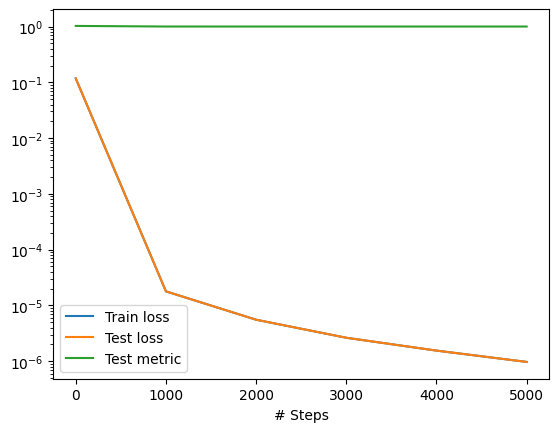

In [23]:
geom = dde.geometry.Hypercube([-1, -1, 1, 1], [1, 1, 2, 2])
bc = dde.icbc.DirichletBC(geom, lambda _: 0, boundary)

data = dde.data.PDE(
    geom, 
    pde, 
    bc, 
    num_domain = 800,
    num_boundary = 100,
    solution=exact_sol,
    train_distribution="uniform"
)
layer_size = [4] + [32] * 4 + [1]
activation = "tanh"
initializer = "Glorot uniform"

net = dde.nn.FNN(layer_size, activation, initializer)

net.apply_output_transform(transform)

model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])

losshistory, train_state = model.train(iterations=5000)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

In [8]:
def generate_test_data(size):
    x = np.linspace(-1, 1, size)
    y = np.linspace(-1, 1, size)
    test_x, test_y = np.meshgrid(x, y)
    test_x = test_x.reshape(-1)
    test_y = test_y.reshape(-1)
    test_domain = np.array([
        data_for_n(test_x, test_y, [1, 1]),
        data_for_n(test_x, test_y, [1, 2]),
        data_for_n(test_x, test_y, [2, 1]),
        data_for_n(test_x, test_y, [2, 2])]
    )
    return test_domain

def data_for_n(x, y, n):
    n1 = np.repeat(n[0], len(x))
    n2 = np.repeat(n[1], len(x))
    return np.vstack((x, y, n1, n2)).T

In [9]:
def get_solution(data):
    solution = np.hstack([model.predict(el) for el in data])
    return solution

In [10]:
def graph_shreodinger(input_data, output_data, title):
    fig, ax = plt.subplots(nrows=2, ncols=2)
    fig.set_size_inches(10, 10)
    fig.suptitle(title)
    for i in range(len(n)):
        n1 = n[i][0] - 1
        n2 = n[i][1] - 1
        contour = ax[n1][n2].tricontour(input_data[i,:,0], input_data[i,:,1], output_data[:, i])
        ax[n1][n2].clabel(contour, inline=1, fontsize=10)

sol [[-0.00216952  0.00146492 -0.0015959   0.00093793]
 [-0.00224611  0.00131873 -0.00162307  0.00088261]
 [-0.00231725  0.00117717 -0.00164831  0.00082965]
 ...
 [ 0.00438931  0.00048447 -0.0010466   0.00156431]
 [ 0.00446146  0.00046286 -0.00110939  0.00159657]
 [ 0.00453859  0.00044528 -0.00116765  0.00163238]]


/tmp/ipykernel_308/3777939649.py:8: RuntimeWarning: divide by zero encountered in divide
  error_l2 = (np.abs(predicted_solution - exact_solution)/exact_solution)**2


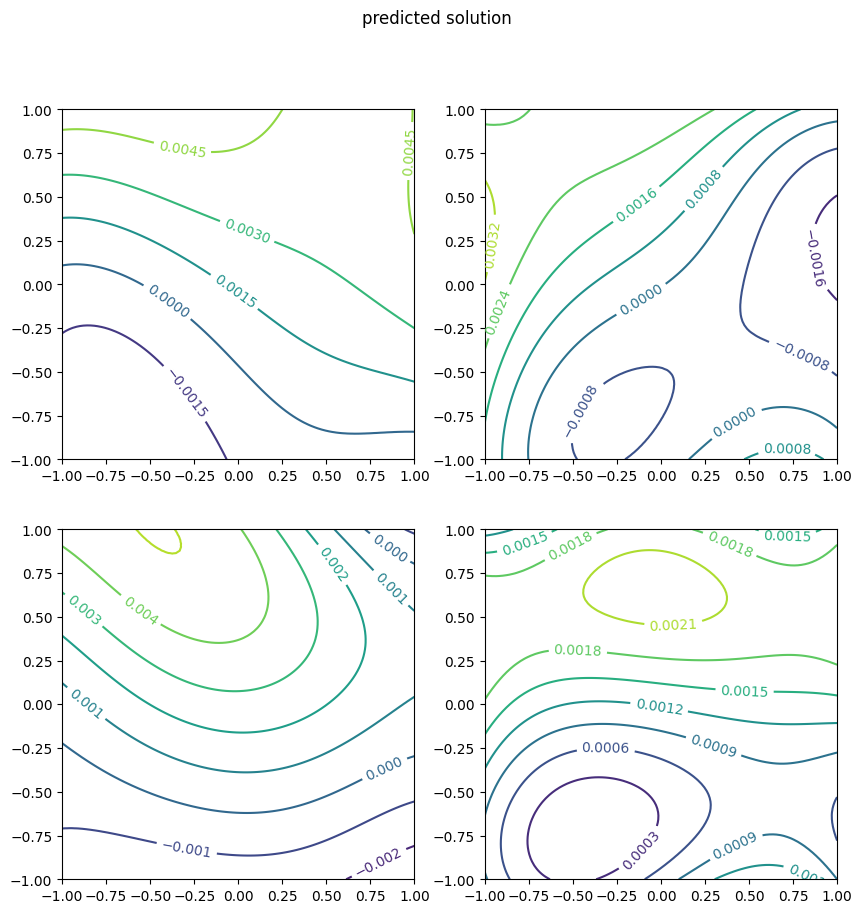

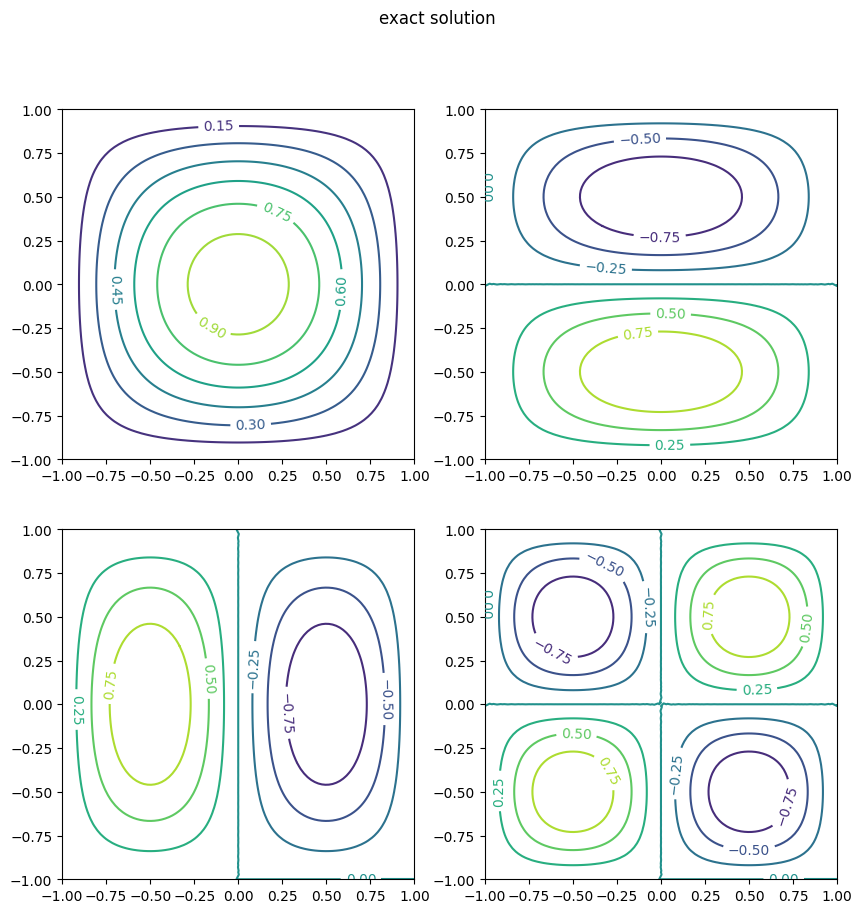

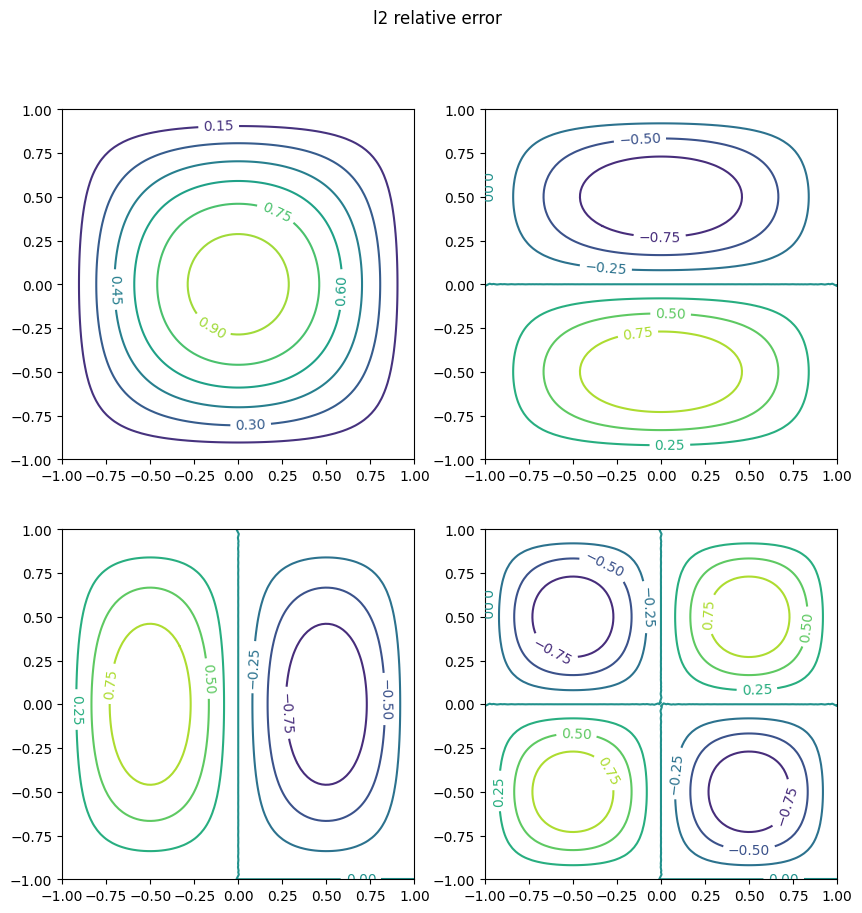

In [20]:
test_domain = generate_test_data(100)
predicted_solution = get_solution(test_domain)
graph_shreodinger(test_domain, predicted_solution, "predicted solution")

exact_solution = np.hstack([exact_sol(el) for el in test_domain])
graph_shreodinger(test_domain, exact_solution, "exact solution")

error_l2 = (np.abs(predicted_solution - exact_solution)/exact_solution)**2
graph_shreodinger(test_domain, exact_solution, "l2 relative error")